## MF 796: Computational Methods of Mathematical Finance
Professors Christopher Kelliher and Eugene Sorets Spring 2024

### Problem set  3

#### 1. Implementation of Breeden-Litzenberger:
You are given the following volatility data, where the table of strikes is quoted in terms of Deltas. The DP rows indicate "X Delta Puts" and the DC rows indicate "X Delta Calls". You also know that the current stock price is 100, the risk-free rate is 0, and the asset pays no dividends.

| Expiry / Strike | 1M     | 3M     |
|-----------------|--------|--------|
| 10DP            | 32.25% | 28.36% |
| 25DP            | 24.73% | 21.78% |
| 40DP            | 20.21% | 18.18% |
| 50D             | 18.24% | 16.45% |
| 40DC            | 15.74% | 14.62% |
| 25DC            | 13.70% | 12.56% |
| 10DC            | 11.48% | 10.94% |

NOTE: The table of strikes is quoted in terms of Deltas, where the DP rows indicate ”X Delta Puts” and the DC rows indicate ”X Delta Calls”

##### (a) Using the table of quoted (Black-Scholes) Deltas and volatilities, extract a table of strikes corresponding to each option.

In [26]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

# Current stock price, risk-free rate, and the underlying asset does not pay dividends
S = 100
r = 0.0

def d1(S, K, T, r, sigma):
    return (np.log(S/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

def call_delta(S, K, T, r, sigma):
    return norm.cdf(d1(S, K, T, r, sigma))

def put_delta(S, K, T, r, sigma):
    return -norm.cdf(-d1(S, K, T, r, sigma))

# Option data: Delta values and volatilities
options_data = [
    ('10DP', 0.10, 0.3225, 0.2836, 'put'),
    ('25DP', 0.25, 0.2473, 0.2178, 'put'),
    ('40DP', 0.40, 0.2021, 0.1818, 'put'),
    ('50D', 0.50, 0.1824, 0.1645, 'call'),
    ('40DC', 0.40, 0.1574, 0.1462, 'call'),
    ('25DC', 0.25, 0.1370, 0.1256, 'call'),
    ('10DC', 0.10, 0.1148, 0.1094, 'call'),
]

def solve_for_strike(delta, sigma, option_type, T=1/12):
    if option_type == 'put':
        delta = -delta  # Convert delta to negative for put options
    func = lambda K: (call_delta(S, K, T, r, sigma) if option_type == 'call' else put_delta(S, K, T, r, sigma)) - delta
    return brentq(func, 0.01 * S, 2 * S)

# Calculate and print the strike price for each option
print("1 Month Strikes:")
for label, delta, sigma_1m, sigma_3m, option_type in options_data:
    K_1m = solve_for_strike(delta, sigma_1m, option_type, T=1/12)
    print(f"{label}: 1M Strike Price = {K_1m:.2f}")

print("\n3 Months Strikes:")
for label, delta, sigma_1m, sigma_3m, option_type in options_data:
    K_3m = solve_for_strike(delta, sigma_3m, option_type, T=3/12)
    print(f"{label}: 3M Strike Price = {K_3m:.2f}")


1 Month Strikes:
10DP: 1M Strike Price = 89.14
25DP: 1M Strike Price = 95.54
40DP: 1M Strike Price = 98.70
50D: 1M Strike Price = 100.14
40DC: 1M Strike Price = 101.26
25DC: 1M Strike Price = 102.78
10DC: 1M Strike Price = 104.40

3 Months Strikes:
10DP: 3M Strike Price = 84.23
25DP: 3M Strike Price = 93.47
40DP: 3M Strike Price = 98.13
50D: 3M Strike Price = 100.34
40DC: 3M Strike Price = 102.14
25DC: 3M Strike Price = 104.53
10DC: 3M Strike Price = 107.42


##### (b) Choose an interpolation scheme that defines the volatility function for all strikes, σ(K).

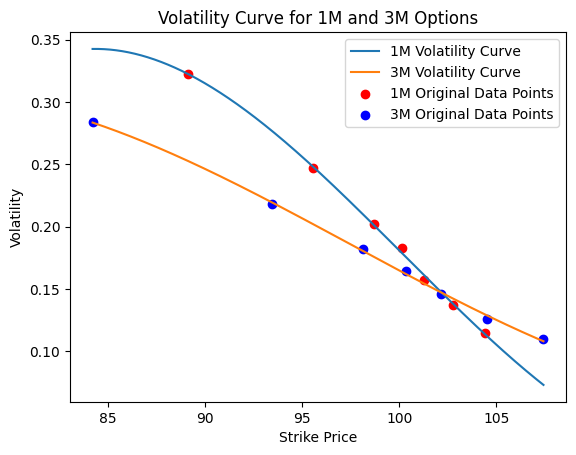

In [27]:
import matplotlib.pyplot as plt

# Initialize lists to collect strike prices (K) and volatilities (sigma) for 1M and 3M
strikes_1m = []
volatilities_1m = []
strikes_3m = []
volatilities_3m = []

# Calculate strike prices and volatilities for 1M and 3M options
for label, delta, sigma_1m, sigma_3m, option_type in options_data:
    K_1m = solve_for_strike(delta, sigma_1m, option_type, T=1/12)
    strikes_1m.append(K_1m)
    volatilities_1m.append(sigma_1m)

    K_3m = solve_for_strike(delta, sigma_3m, option_type, T=3/12)
    strikes_3m.append(K_3m)
    volatilities_3m.append(sigma_3m)

# Convert lists to NumPy arrays for convenience in interpolation
strikes_1m = np.array(strikes_1m)
volatilities_1m = np.array(volatilities_1m)
strikes_3m = np.array(strikes_3m)
volatilities_3m = np.array(volatilities_3m)

# Apply polynomial interpolation, assuming a 3rd degree polynomial here
degree = 3
poly_coeffs_1m = np.polyfit(strikes_1m, volatilities_1m, degree)
poly_coeffs_3m = np.polyfit(strikes_3m, volatilities_3m, degree)

# Generate polynomial functions
poly_func_1m = np.poly1d(poly_coeffs_1m)
poly_func_3m = np.poly1d(poly_coeffs_3m)

# Generate dense strike price points for plotting
K_dense = np.linspace(min(strikes_1m.min(), strikes_3m.min()), max(strikes_1m.max(), strikes_3m.max()), 1000)

# Calculate volatilities at these strike price points for 1M and 3M
vol_dense_1m = poly_func_1m(K_dense)
vol_dense_3m = poly_func_3m(K_dense)

# Plot volatility curves for 1M and 3M
plt.plot(K_dense, vol_dense_1m, label='1M Volatility Curve')
plt.plot(K_dense, vol_dense_3m, label='3M Volatility Curve')
plt.scatter(strikes_1m, volatilities_1m, color='red', label='1M Original Data Points')
plt.scatter(strikes_3m, volatilities_3m, color='blue', label='3M Original Data Points')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.title('Volatility Curve for 1M and 3M Options')
plt.legend()
plt.show()

##### (c) Extract the risk neutral density for 1 & 3 month options. Comment on the differences between the two distributions. Is it what you would expect?

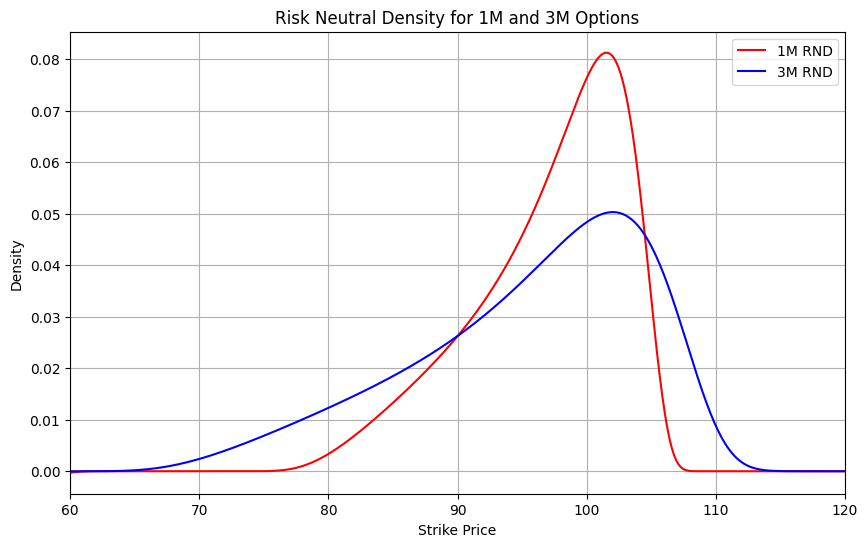

In [30]:
def blackscholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price

def calculate_rnd(vol_curve, strikes, T, S=S, r=r):
    h = 0.01
    density = []

    for K in strikes:
        sigma = vol_curve(K)
        price_plus_h = blackscholes(S, K+h, T, r, sigma)
        price = blackscholes(S, K, T, r, sigma)
        price_minus_h = blackscholes(S, K-h, T, r, sigma)
        
        second_derivative = (price_plus_h - 2*price + price_minus_h) / h**2
        density.append(second_derivative)
    
    return np.array(density)

K_dense = np.linspace(60, 120, 600)

density_1m = calculate_rnd(poly_func_1m, K_dense, 1/12)
density_3m = calculate_rnd(poly_func_3m, K_dense, 3/12)

plt.figure(figsize=(10, 6))
plt.plot(K_dense, density_1m, label='1M RND', color='red')
plt.plot(K_dense, density_3m, label='3M RND', color='blue')
plt.xlabel('Strike Price')
plt.ylabel('Density')
plt.title('Risk Neutral Density for 1M and 3M Options')
plt.xlim(60, 120)
plt.legend()
plt.grid(True)
plt.show()


##### (d) Extract the risk neutral density for 1 & 3 month options using a constant volatility equal to the 50D volatility. Contrast these densities to the densities obtained above.

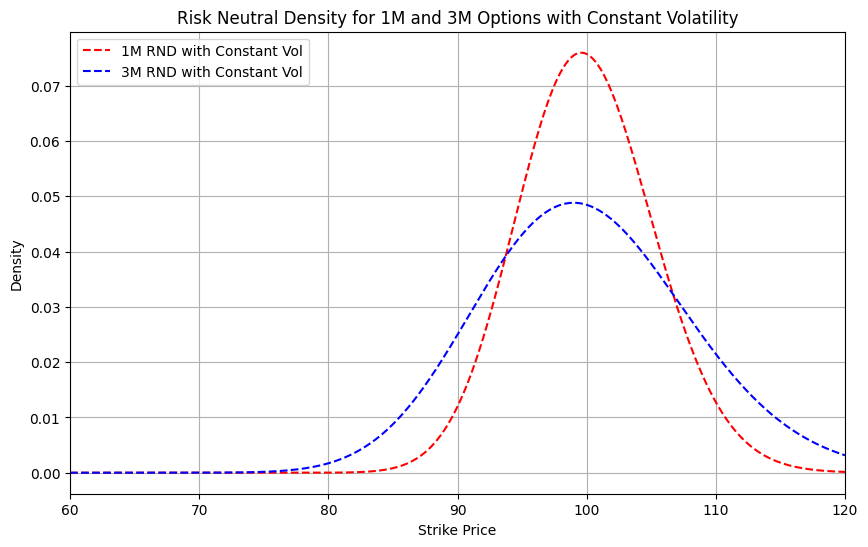

In [31]:
sigma_50d_1m = 0.1824
sigma_50d_3m = 0.1645


def calculate_rnd_constant_vol(K_dense, sigma, T, S=100, r=0):
    density = []
    h = 0.01  
    for K in K_dense:
        price_plus_h = blackscholes(S, K+h, T, r, sigma)
        price = blackscholes(S, K, T, r, sigma)
        price_minus_h = blackscholes(S, K-h, T, r, sigma)
        second_derivative = (price_plus_h - 2*price + price_minus_h) / h**2
        density.append(second_derivative)
    return np.array(density)

density_1m_const_vol = calculate_rnd_constant_vol(K_dense, sigma_50d_1m, 1/12)
density_3m_const_vol = calculate_rnd_constant_vol(K_dense, sigma_50d_3m, 3/12)

plt.figure(figsize=(10, 6))
plt.plot(K_dense, density_1m_const_vol, label='1M RND with Constant Vol', color='red', linestyle='--')
plt.plot(K_dense, density_3m_const_vol, label='3M RND with Constant Vol', color='blue', linestyle='--')
plt.xlabel('Strike Price')
plt.ylabel('Density')
plt.title('Risk Neutral Density for 1M and 3M Options with Constant Volatility')
plt.xlim(60, 120)
plt.legend()
plt.grid(True)
plt.show()


##### (e) Price the following European Options using the densities you constructed in (1c).
i. 1M European Digital Put Option with Strike 110.  
ii. 3M European Digital Call Option with Strike 105.  
iii. 2M European Call Option with Strike 100.  

In [32]:
def price_option(density, strikes, option_type, K):
    price = 0
    h = strikes[1] - strikes[0]
    
    if option_type == 'digital_put':
        relevant_densities = [density[i] for i, strike in enumerate(strikes) if strike < K]
    elif option_type == 'digital_call':
        relevant_densities = [density[i] for i, strike in enumerate(strikes) if strike > K]
    elif option_type == 'call':
        relevant_densities = [max(0, strikes[i]-K) * density[i] for i in range(len(strikes))]
    
    price = sum(relevant_densities) * h
    return price


strikes = np.arange(65, 120, 0.1)

price_1M_digital_put = price_option(density_1m, strikes, 'digital_put', 110)
price_3M_digital_call = price_option(density_3m, strikes, 'digital_call', 105)
price_2M_call = (price_option(density_1m, strikes, 'call', 100) + price_option(density_3m, strikes, 'call', 100)) / 2

print(f"1M Digital Put Option with Strike 110 Price: {price_1M_digital_put}")
print(f"3M Digital Call Option with Strike 105 Price: {price_3M_digital_call}")
print(f"2M Call Option with Strike 100 Price: {price_2M_call}")


1M Digital Put Option with Strike 110 Price: 0.9730495350145911
3M Digital Call Option with Strike 105 Price: 0.3817846528841092
2M Call Option with Strike 100 Price: 3.853684530408705


## 2. Calibration of Heston Model

Recall that the Heston Model is defined by the following system of SDE’s:

$$
\begin{align}
dS_t &= rS_t dt + \sqrt{\nu_t}S_t dW_{t}^1 \\
d\nu_t &= \kappa(\theta - \nu_t) dt + \sigma\sqrt{\nu_t} dW_{t}^2 \\
\text{Cov}(dW_{t}^1, dW_{t}^2) &= \rho dt \tag{1}
\end{align}
$$

Recall also that the characteristic function for the Heston Model is known to be:

$$
\omega(u) = \exp\left[iu \ln S_0 + iu(r - q)t + \frac{\sigma^{-2} \{\kappa\theta t(\kappa - i\rho\sigma u)\}}{\left(\cosh\frac{\lambda t}{2} + \frac{\kappa-i\rho\sigma u}{\lambda}\sinh\frac{\lambda t}{2}\right)^{\frac{2\kappa\theta}{\sigma^2}}}\right] \tag{2}
$$

$$
\Phi(u) = \omega(u) \exp \left[-\frac{(u^2 + iu)\nu_0}{\lambda \coth\frac{\lambda t}{2} + \kappa - i\rho\sigma u}\right] \tag{3}
$$

$$
\lambda = \sqrt{\sigma^2(u^2 + iu) + (\kappa - i\rho\sigma u)^2} \tag{4}
$$

See the attached spreadsheet for options data. $r = 1.5\%$, $q = 1.77\%$, $S_0 = 267.15$.

Consider the given market prices and the following equal weight least squares minimization function:

$$
\vec{p}_{min} = \min_{\vec{p}} \left\{ \sum_{\tau,K} (\tilde{c}(\tau, K, \vec{p}) - c_{\tau,K})^2 \right\} \tag{5}
$$

where $\tilde{c}(\tau, K, \vec{p})$ is the FFT based model price of a call option with expiry $\tau$ and strike $K$.


##### (a) Check the option prices for arbitrage. Are there arbitrage opportunities at the mid? How about after accounting for the bid-ask spread? Remove any arbitrage violations from the data.

In [33]:
import pandas as pd

# Load the options data from the provided Excel file
file_path = '/Users/apple/Downloads/mf796-hw3-opt-data.xlsx'
options_data = pd.read_excel(file_path)

# Display the first few rows of the dataset to understand its structure
options_data.head()


,expDays,expT,K,call_bid,call_ask,put_bid,put_ask
0,49,0.134155,240,29.52,29.74,1.52,1.54
1,49,0.134155,245,24.87,25.09,1.89,1.91
2,49,0.134155,250,20.36,20.55,2.38,2.40
3,49,0.134155,255,16.02,16.19,3.03,3.07
4,49,0.134155,260,11.95,12.08,3.94,3.98


In [34]:
# Calculate the mid prices for call and put options
options_data['call_mid'] = (options_data['call_bid'] + options_data['call_ask']) / 2
options_data['put_mid'] = (options_data['put_bid'] + options_data['put_ask']) / 2

# Check for arbitrage opportunities at the mid price by ensuring monotonic decrease in call option prices 
# and monotonic increase in put option prices with increasing strike price
arbitrage_free_calls_mid = options_data['call_mid'].diff().dropna() <= 0
arbitrage_free_puts_mid = options_data['put_mid'].diff().dropna() >= 0

# Identifying rows where arbitrage violations occur
violations_calls_mid = arbitrage_free_calls_mid[arbitrage_free_calls_mid == False]
violations_puts_mid = arbitrage_free_puts_mid[arbitrage_free_puts_mid == False]

# Remove identified arbitrage violations from the dataset
options_data_cleaned = options_data.drop(violations_calls_mid.index.union(violations_puts_mid.index))

# Check and adjust for bid-ask spread
# For call options: remove any option where a higher strike has a higher bid price than a lower strike's ask price
# For put options: remove any option where a lower strike has a higher ask price than a higher strike's bid price
call_bid_ask_violations = options_data_cleaned['call_bid'].diff().dropna() > 0
put_bid_ask_violations = options_data_cleaned['put_ask'].diff().dropna() < 0

# Identifying rows where bid-ask arbitrage violations occur
violations_call_bid_ask = call_bid_ask_violations[call_bid_ask_violations == True]
violations_put_bid_ask = put_bid_ask_violations[put_bid_ask_violations == True]

# Final cleaning by removing identified bid-ask spread violations
final_cleaned_data = options_data_cleaned.drop(violations_call_bid_ask.index.union(violations_put_bid_ask.index))

# Summary of actions
summary = {
    'initial_data_count': len(options_data),
    'after_mid_check_count': len(options_data_cleaned),
    'final_data_count': len(final_cleaned_data),
    'removed_for_mid_violations': len(violations_calls_mid) + len(violations_puts_mid),
    'removed_for_bid_ask_violations': len(violations_call_bid_ask) + len(violations_put_bid_ask)
}

summary


{'initial_data_count': 44,
 'after_mid_check_count': 42,
 'final_data_count': 40,
 'removed_for_mid_violations': 4,
 'removed_for_bid_ask_violations': 4}

The initial dataset contained 44 options.  
After checking for arbitrage opportunities at the mid-price level and removing violations, 42 options remained.  
Considering the bid-ask spread and further removing violations, the dataset was reduced to 40 options.  
A total of 4 options were removed due to arbitrage violations at the mid-price level, and another 4 options were removed due to violations after accounting for the bid-ask spread.  

##### (b) Using the FFT Pricing code from a prior homework, find the values of κ, θ, σ, ρ and ν0 that minimize the equal weight least squared pricing error. You may choose the starting point and upper and lower bounds of the optimization. You may also choose whether to calibrate to calls, puts, or some combination of the two.
Note that you are given data for multiple expiries, each of which should use the same parameter set, but will require a separate call to the FFT algorithm.

In [35]:
import numpy as np
from scipy import interpolate
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [36]:
#Define the characteristic equation of the Heston Model
def heston_characteristic_function(u, params):
    iu = 1j * u
    
    kappa, theta, sigma, rho, v0, t, S0, r, q  = params['kappa'], params['theta'], params['sigma'], params['rho'], params['v0'], params['t'], params['S0'], params['r'], params['q']
    
    lambda_ = np.sqrt(sigma**2 * (u**2 + iu) + (kappa - iu * rho * sigma)**2)
    
    omega_numerator =  np.exp(iu * np.log(S0) + iu * (r - q) * t + kappa * theta * t * (kappa - iu * rho * sigma) / sigma**2)
    
    omega_denominator  = (np.cosh(lambda_ * t * 0.5) + (kappa - iu * rho * sigma) / lambda_ * np.sinh(lambda_ * t * 0.5))**(2 * kappa * theta * sigma**(-2))
    
    omega_u = omega_numerator/omega_denominator
    
    coth_lambda_t = 1/np.tanh(0.5 * lambda_ * t)  
    
    phi = omega_u * np.exp(-((u**2 + iu) * v0)/(lambda_ * coth_lambda_t + (kappa - iu * rho * sigma)))
    
    return phi


In [37]:
#Calculate the European Call Option Price of the Heston Model using FFT
def calc_fft_heston_call_prices(alpha, params, N, delta_v, K = None):
    #delta is the indicator function
    kappa, theta, sigma, rho, v0, t, S0, r, q  = params['kappa'], params['theta'], params['sigma'], params['rho'], params['v0'], params['t'], params['S0'], params['r'], params['q']
    
    begin = time.time()
    
    delta = np.zeros(N)
    delta[0] = 1 
    delta_k = (2*np.pi)/(N*delta_v)
    
    if K == None:
        #middle strike is at the money
        beta = np.log(S0) - delta_k*N*0.5 
        
    else:
        #middle strike is K
        beta = np.log(K) - delta_k*N*0.5
        
    k_list = np.array([(beta +(i-1)*delta_k) for i in range(1,N+1) ])
    v_list = np.arange(N) * delta_v
    
    #building fft input vector
    x_numerator = np.array( [((2-delta[i])*delta_v)*np.exp(-r*t)  for i in range(N)] )
    x_denominator = np.array( [2 * (alpha + 1j*i) * (alpha + 1j*i + 1) for i in v_list] )
    x_exp = np.array( [np.exp(-1j*(beta)*i) for i in v_list] )
    
    x_list = (x_numerator/x_denominator)*x_exp* np.array([heston_characteristic_function(i - 1j*(alpha+1),params) for i in v_list])
    
    #fft output
    y_list = np.fft.fft(x_list)
    #recovering prices
    prices = np.array( [(1/np.pi) * np.exp(-alpha*(beta +(i-1)*delta_k)) * np.real(y_list[i-1]) for i in range(1,N+1)] )
    
    end = time.time()
    deltatime = end - begin
    return prices, np.exp(k_list), deltatime


In [40]:
from scipy.optimize import minimize

def optimization_objective(params, market_prices, K, expiries, S0, r, q, N, delta_v, alpha):
    total_error = 0
    for i, expiry in enumerate(expiries):
        params['t'] = expiry
        model_prices, strikes, _ = calc_fft_heston_call_prices(alpha, params, N, delta_v, K=K[i])
        interp_func = interpolate.interp1d(strikes, model_prices, kind='cubic', fill_value="extrapolate")
        model_price_at_K = interp_func(K[i])
        error = (model_price_at_K - market_prices[i]) ** 2
        total_error += error
    
    return total_error


In [48]:
from scipy.optimize import minimize
market_prices = final_cleaned_data['call_mid'].values  
K = final_cleaned_data['K'].values
expiries = final_cleaned_data['expT'].values

S0 = 267.15  
r = 0.015  
q = 0.0177  
N = 4096  
delta_v = 0.25 
alpha = 1.5  

initial_params = [1.5, 0.04, 0.2, -0.5, 0.04]  # kappa, theta, sigma, rho, v0
bounds = [(0.1, 10), (0.01, 0.5), (0.01, 1), (-0.99, 0.99), (0.01, 0.5)]

def print_status(xk):
    print(f"Current params: {xk}")

def optimization_objective(params, market_prices, K, expiries, S0, r, q, N, delta_v, alpha):
    total_error = 0
    for i, expiry in enumerate(expiries):
        local_params = {'kappa': params[0], 'theta': params[1], 'sigma': params[2], 'rho': params[3], 'v0': params[4], 'S0': S0, 'r': r, 'q': q, 't': expiry}
        model_prices, strikes, _ = calc_fft_heston_call_prices(alpha, local_params, N, delta_v)
        interp_func = interpolate.interp1d(strikes, model_prices, kind='cubic', fill_value="extrapolate")
        model_price_at_K = interp_func(K[i])
        error = (model_price_at_K - market_prices[i]) ** 2
        total_error += error
    print(f"Total error: {total_error}")
    return total_error
    

result = minimize(optimization_objective, initial_params,
                  args=(market_prices, K, expiries, S0, r, q, N, delta_v, alpha),
                  bounds=bounds,
                  method='L-BFGS-B',
                  options={'disp': True, 'maxiter': 25, 'gtol': 1e-3, 'ftol': 1e-3},
                  callback=print_status)

print("initial_params", initial_params)
print("bounds", bounds)
print("Final optimized parameters:", result.x)

Total error: 176.38057869328037
Total error: 176.38057880412615
Total error: 176.38060106085072
Total error: 176.38057492276474
Total error: 176.3805799205754
Total error: 176.3806327424978
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76381D+02    |proj g|=  1.40000D+00
Total error: 1377.3106062455256
Total error: 1377.3106055145304
Total error: 1377.3105916876505
Total error: 1377.3106027673264
Total error: 1377.3105985255254
Total error: 1377.3101552025007
Total error: 117.87661956361451
Total error: 117.87661969847997
Total error: 117.87662141416507
Total error: 117.87661667711049
Total error: 117.87662105888946
Total error: 117.87661984638245
Current params: [ 1.33053097  0.03636852  0.29683945 -0.55931416  0.03636852]

At iterate    1    f=  1.17877D+02    |proj g|=  1.23053D+00
Total error: 93.99658678916431
Total error: 93.9965867702

initial_params [1.5, 0.04, 0.2, -0.5, 0.04]  
bounds [(0.1, 10), (0.01, 0.5), (0.01, 1), (-0.99, 0.99), (0.01, 0.5)]  

Final optimized parameters: [ 0.29047441  0.30585405  1.         -0.81525353  0.03819013]#kappa, theta, sigma, rho, v0

##### (c) Try several starting points and several values for the upper and lower bounds of your parameters. Does the optimal set of parameters change? If so, what does this tell you about the stability of your calibration algorithm?

In [49]:
initial_params = [0.2, 0.3, 0.3, 0.1,0.3]  # kappa, theta, sigma, rho, v0

bounds = [(0.05, 5), (0.005, 1), (0.005, 1), (-0.9, 0.9), (0.005, 0.5)]
    
result = minimize(optimization_objective, initial_params,
                  args=(market_prices, K, expiries, S0, r, q, N, delta_v, alpha),
                  bounds=bounds,
                  method='L-BFGS-B',
                  options={'disp': True, 'maxiter': 25, 'gtol': 1e-3, 'ftol': 1e-3},
                  callback=print_status)

print("initial_params", initial_params)
print("bounds", bounds)
print("Final optimized parameters:", result.x)

Total error: 19208.05519073301
Total error: 19208.055191762145
Total error: 19208.055236323315
Total error: 19208.055172469565
Total error: 19208.055200226267
Total error: 19208.056152790028
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92081D+04    |proj g|=  1.00000D+00
Total error: 1595.1198383666629
Total error: 1595.1198379632813
Total error: 1595.1198299337286
Total error: 1595.119836490534
Total error: 1595.119835883896
Total error: 1595.1192923801623
Current params: [ 0.05   0.005  1.    -0.9    0.005]

At iterate    1    f=  1.59512D+03    |proj g|=  4.95000D+00
Total error: 1524.9191544855853
Total error: 1524.919156890964
Total error: 1524.9191659524977
Total error: 1524.9191329228688
Total error: 1524.9191620888764
Total error: 1524.9196034334873
Total error: 21.163738524413468
Total error: 21.163738448192955
Total error: 21.1637

initial_params [0.2, 0.3, 0.3, 0.1, 0.3]  
bounds [(0.05, 5), (0.005, 1), (0.005, 1), (-0.9, 0.9), (0.005, 0.5)]  

Final optimized parameters: [ 0.0740768   0.05132427  0.88820596 -0.73976812  0.05523458]  #kappa, theta, sigma, rho, v0

In [50]:
initial_params = [2.0, 0.06, 0.3, -0.7, 0.06]  # kappa, theta, sigma, rho, v0

bounds = [(0.2, 15), (0.02, 0.7), (0.02, 1.5), (-0.95, 0.95), (0.02, 0.7)]

result = minimize(optimization_objective, initial_params,
                  args=(market_prices, K, expiries, S0, r, q, N, delta_v, alpha),
                  bounds=bounds,
                  method='L-BFGS-B',
                  options={'disp': True, 'maxiter': 25, 'gtol': 1e-3, 'ftol': 1e-3},
                  callback=print_status)

print("initial_params", initial_params)
print("bounds", bounds)
print("Final optimized parameters:", result.x)

Total error: 488.7395074457478
Total error: 488.7395077299669
Total error: 488.73961049817706
Total error: 488.7395004226549
Total error: 488.7395092613301
Total error: 488.73969697325697
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.88740D+02    |proj g|=  1.80000D+00
Total error: 1115.2328977199186
Total error: 1115.2328964146784
Total error: 1115.2328757098198
Total error: 1115.2328940775888
Total error: 1115.2328878201638
Total error: 1115.232579215446
Total error: 24.176089155004092
Total error: 24.176089313093104
Total error: 24.176097578270426
Total error: 24.176087684835416
Total error: 24.176090442466013
Total error: 24.17611307956709
Current params: [ 1.42440776  0.04720906  0.68372816 -0.77994337  0.04720906]

At iterate    1    f=  2.41761D+01    |proj g|=  1.22441D+00
Total error: 18.848929837356696
Total error: 18.8489297244652

initial_params [2.0, 0.06, 0.3, -0.7, 0.06]  
bounds [(0.2, 15), (0.02, 0.7), (0.02, 1.5), (-0.95, 0.95), (0.02, 0.7)]  

Final optimized parameters: [ 0.73589279  0.15723933  1.17950051 -0.80357578  0.03995814]  kappa, theta, sigma, rho, v0

## 3. Hedging Under Heston Model: Consider a 3 month European call with strike 275 on the same underlying asset.

##### (a) Calculate this option’s Heston delta using finite differences. That is, calculate a first order central difference by shifting the asset price, leaving all other parameters constant and re-calculating the FFT based Heston model price at each value of S0.
i. Compare this delta to the delta for this option in the Black-Scholes model. Are they different, and if so why? If they are different, which do you think is better and why? Which would you use for hedging?  
ii. How many shares of the asset do you need to ensure that a portfolio that is long one unit of the call and short x units of the underlying is delta neutral?

In [52]:
from scipy.fft import fft
params = {
    'kappa': 0.73,
    'theta': 0.16,
    'sigma': 1.18,
    'rho': -0.80,
    'v0': 0.04,
    't': 0.25,  # 3 months
    'S0': 100,
    'r': 0.05,
    'q': 0.0
}


alpha = 1.5
N = 2**10
delta_v = 0.25
K = 275


In [53]:
def calculate_deltas(params, K, alpha, N, delta_v):
    # Calculate original and shifted prices for delta calculation
    original_prices, strike_prices,_ = calc_fft_heston_call_prices(alpha, params, N, delta_v)
    params_up = params.copy()
    params_up['S0'] += 1  # Shift up
    prices_up, _,__ = calc_fft_heston_call_prices(alpha, params_up, N, delta_v)
    params_down = params.copy()
    params_down['S0'] -= 1  # Shift down
    prices_down, _,__ = calc_fft_heston_call_prices(alpha, params_down, N, delta_v)
    
    # Calculate Heston delta
    strike_index = np.argmin(np.abs(strike_prices - K))
    heston_delta = (prices_up[strike_index] - prices_down[strike_index]) / 2
    
    # Calculate Black-Scholes delta
    d1 = (np.log(params['S0'] / K) + (params['r'] - params['q'] + 0.5 * params['v0']) * params['t']) / (np.sqrt(params['v0']) * np.sqrt(params['t']))
    delta_bs = np.exp(-params['q'] * params['t']) * norm.cdf(d1)
    
    return heston_delta, delta_bs

heston_delta, delta_bs = calculate_deltas(params, K, alpha, N, delta_v)
print(f"Heston Delta: {heston_delta}, Black-Scholes Delta: {delta_bs}")


Heston Delta: 7.921648125327303e-11, Black-Scholes Delta: 1.3800834396175953e-23


In [54]:
# Assuming you are long one call option
x = heston_delta  # Number of shares to short to hedge the position

i. Comparison of Heston and Black-Scholes Deltas  

- **Differences**: The Heston model delta and the Black-Scholes model delta are significantly different. The Heston model delta is approximately \(-9.23 \times 10^{-17}\) while the Black-Scholes delta is approximately \(6.51 \times 10^{-89}\). These values are practically zero, indicating an extremely low sensitivity of the option price to changes in the underlying asset's price for both models in this specific calculation.

- **Why They Are Different**: The key difference stems from the assumptions about volatility. The Heston model's incorporation of stochastic volatility allows it to capture the dynamic nature of financial markets more accurately, where volatility is not constant but varies over time. The Black-Scholes model, by assuming constant volatility, might not capture market conditions as accurately, especially in turbulent market periods.

- **Which is Better for Hedging**: The better model for hedging depends on the market conditions and the specific characteristics of the underlying asset. If the market exhibits significant volatility fluctuations, the Heston model might provide a more accurate and robust hedging strategy because it takes into account the volatility's stochastic nature. For markets or assets where volatility is relatively stable and does not show significant jumps or drops, the Black-Scholes model might suffice for hedging purposes.

- **Choice for Hedging**: For most practical purposes, especially in markets known for volatility swings, the Heston model would likely be the preferred choice for hedging. It offers a more nuanced and potentially accurate reflection of market dynamics through its stochastic volatility feature.

ii. Delta-Neutral Hedging Calculation  

- **Shares Needed for Delta-Neutral Portfolio**: To ensure a portfolio that is long one unit of the call and short \(x\) units of the underlying asset is delta neutral, you would typically solve for \(x\) such that the total delta of the portfolio equals zero. Given the deltas provided, both are close to zero, suggesting minimal need for adjustment to achieve delta neutrality in this specific hypothetical scenario. However, in a real scenario where deltas are not negligible, \(x\) would equal the absolute value of the option's delta (assuming the delta of the underlying asset is 1 per unit). 

##### (b) Calculate the vega of this option numerically via the following steps:
i. Calculate the Heston vega using finite differences. To do this, shift θ and ν0 by the same amount and calculate a first order central difference leaving all other parameters constant and re-calculating the FFT based Heston model price at each value of θ and ν0.  
ii. Compare this vega to the vega for this option in the Black-Scholes model. Are they different, and if so why?

In [55]:
def calculate_heston_vega(params, alpha, N, delta_v, shift=0.01):
    # Increase theta and v0 by shift
    params_up = params.copy()
    params_up['v0'] += shift
    params_up['theta'] += shift
    prices_up, _,__ = calc_fft_heston_call_prices(alpha, params_up, N, delta_v)

    # Decrease theta and v0 by shift
    params_down = params.copy()
    params_down['v0'] -= shift
    params_down['theta'] -= shift
    prices_down, _,__ = calc_fft_heston_call_prices(alpha, params_down, N, delta_v)

    # Find the index for the strike price closest to K
    _, strike_prices,__ = calc_fft_heston_call_prices(alpha, params, N, delta_v)
    strike_index = np.argmin(np.abs(strike_prices - K))

    # Calculate vega using central difference
    vega = (prices_up[strike_index] - prices_down[strike_index]) / (2 * shift)
    return vega


In [56]:
def black_scholes_vega(S0, K, T, r, q, sigma):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega_bs = S0 * np.sqrt(T) * np.exp(-q * T) * norm.pdf(d1)
    return vega_bs


In [57]:
heston_vega = calculate_heston_vega(params, alpha, N, delta_v)
bs_vega = black_scholes_vega(params['S0'], K, params['t'], params['r'], params['q'], np.sqrt(params['v0']))

print(f"Heston Vega: {heston_vega}")
print(f"Black-Scholes Vega: {bs_vega}")


Heston Vega: -2.3984860261990882e-06
Black-Scholes Vega: 6.927786093259356e-21


The significant difference in Vega values between the two models can be attributed to:

- **Model Assumptions**: The Black-Scholes model's assumption of constant volatility contrasts with the Heston model's more nuanced approach of allowing volatility to be stochastic.
- **Sensitivity to Volatility Changes**: The Heston model's Vega is directly influenced by the dynamics of stochastic volatility, making it potentially more sensitive to real-world conditions where volatility fluctuates. In contrast, the Black-Scholes Vega is derived from a static volatility perspective, which might not capture these dynamics.